In [1]:
import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/nycmap/nyc_-74.3_-73.7_40.5_40.9.png
../input/iiitb2019nyctaxifare/GCP-Coupons-Instructions.rtf
../input/iiitb2019nyctaxifare/sample_submission.csv
../input/iiitb2019nyctaxifare/TrainTest/test.csv
../input/iiitb2019nyctaxifare/TrainTest/train.csv


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns
import folium
import lightgbm as lgbm
import os
import calendar


from math import cos, asin, sqrt


# 1. Exploratory Data Analysis

In [3]:
# Reading Data
train_df =  pd.read_csv('../input/iiitb2019nyctaxifare/TrainTest/train.csv', nrows = 10000000)
#Drop rows with null values
test_df =  pd.read_csv('../input/iiitb2019nyctaxifare/TrainTest/test.csv')



/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
BB = (-74.30, -73.7, 40.50, 40.9)
nyc_map = plt.imread('../input/nycmap/nyc_-74.3_-73.7_40.5_40.9.png')

In [5]:
print(train_df.iloc[4_000_000])
train_df.drop(train_df.index[4_000_000],inplace=True)

key                                key
fare_amount                fare_amount
pickup_datetime        pickup_datetime
pickup_longitude      pickup_longitude
pickup_latitude        pickup_latitude
dropoff_longitude    dropoff_longitude
dropoff_latitude      dropoff_latitude
passenger_count        passenger_count
Name: 4000000, dtype: object


In [6]:
print(train_df.iloc[8_000_000])
train_df.drop(train_df.index[8_000_000],inplace=True)

key                                key
fare_amount                fare_amount
pickup_datetime        pickup_datetime
pickup_longitude      pickup_longitude
pickup_latitude        pickup_latitude
dropoff_longitude    dropoff_longitude
dropoff_latitude      dropoff_latitude
passenger_count        passenger_count
Name: 8000001, dtype: object


In [7]:
train_df = train_df.dropna(how = 'any', axis = 'rows')

In [8]:
train_df["pickup_longitude"] = train_df.pickup_longitude.astype(float)
train_df["pickup_latitude"] = train_df.pickup_latitude.astype(float)
train_df["dropoff_longitude"] = train_df.dropoff_longitude.astype(float)
train_df["dropoff_latitude"] = train_df.dropoff_latitude.astype(float)
train_df["passenger_count"] = train_df.passenger_count.astype(int)
train_df["fare_amount"] = train_df.fare_amount.astype(float)

In [9]:
test_df["pickup_longitude"] = test_df.pickup_longitude.astype(float)
test_df["pickup_latitude"] = test_df.pickup_latitude.astype(float)
test_df["dropoff_longitude"] = test_df.dropoff_longitude.astype(float)
test_df["dropoff_latitude"] = test_df.dropoff_latitude.astype(float)
test_df["passenger_count"] = test_df.passenger_count.astype(int)


In [10]:
train_df.head(5)

key  fare_amount          pickup_datetime  \
0   2014-09-27 15:26:00.00000043          7.5  2014-09-27 15:26:00 UTC   
1  2012-05-07 07:57:00.000000142          6.5  2012-05-07 07:57:00 UTC   
2    2009-05-05 20:02:36.0000005         12.9  2009-05-05 20:02:36 UTC   
3   2010-07-15 22:57:00.00000042         20.1  2010-07-15 22:57:00 UTC   
4   2010-08-31 13:15:00.00000028          4.1  2010-08-31 13:15:00 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.978463        40.759072         -73.963577         40.774255   
1        -73.982397        40.770245         -73.972450         40.764062   
2        -74.006507        40.718808         -73.961096         40.760711   
3        -73.999242        40.734165         -73.972597         40.751228   
4        -73.977750        40.746274         -73.972760         40.755768   

   passenger_count  
0                1  
1                1  
2                1  
3                2  
4                1

In [11]:
train_df.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  9.999929e+06      9.999929e+06     9.999929e+06       9.999929e+06   
mean   1.133818e+01     -7.250836e+01     3.992149e+01      -7.250917e+01   
std    9.791566e+00      1.287952e+01     9.268963e+00       1.285499e+01   
min   -1.077500e+02     -3.439245e+03    -3.492264e+03      -3.426601e+03   
25%    6.000000e+00     -7.399208e+01     4.073489e+01      -7.399140e+01   
50%    8.500000e+00     -7.398181e+01     4.075263e+01      -7.398016e+01   
75%    1.250000e+01     -7.396709e+01     4.076712e+01      -7.396369e+01   
max    1.273310e+03      3.457626e+03     3.352849e+03       3.457622e+03   

       dropoff_latitude  passenger_count  
count      9.999929e+06     9.999929e+06  
mean       3.991940e+01     1.684654e+00  
std        9.253333e+00     1.328111e+00  
min       -3.488080e+03     0.000000e+00  
25%        4.073403e+01     1.000000e+00  
50%        4.075315e+01     1.000000e+00  
75%        4.076810e+01     2.000000e+00  
max        3.400392e+03     2.080000e+02

## Observation from the above statistics:
1. 'fare_amount' column has negative values
2. Mean of 'fare_amount' is around 12 but max value is 419
3. We are concerned about New York lat long bounds but some of lat long info is lying outside these bounds as well as some values are wrong data
4. 'passenger_count' has min value 0 and max value ______ and so we need to further probe about these outliers as taxi cannot go empty or cannot acommodate more than 8 person


### We check the data points lying outside the New York boundries

In [12]:
a = train_df.shape[0]
print ("Number of pickup records = ",a)
temp_df = train_df[((train_df.dropoff_longitude >= -74.15) & (train_df.dropoff_longitude <= -73.7004) &\
                       (train_df.dropoff_latitude >= 40.5774) & (train_df.dropoff_latitude <= 40.9176)) & \
                       ((train_df.pickup_longitude >= -74.15) & (train_df.pickup_latitude >= 40.5774)& \
                       (train_df.pickup_longitude <= -73.7004) & (train_df.pickup_latitude <= 40.9176))]
b = temp_df.shape[0]
print ("Number of coordinates lying outside NewYork boundaries : ",(a-b))
print ("Percentage of coordinates lying inside NewYork boundaries : ",(b/a)*100)
print ("Percentage of coordinates lying outside NewYork boundaries : ",100-((b/a)*100))



Number of pickup records =  9999929
Number of coordinates lying outside NewYork boundaries :  240671
Percentage of coordinates lying inside NewYork boundaries :  97.59327291223767
Percentage of coordinates lying outside NewYork boundaries :  2.4067270877623343


Only 2.41% data is lying outside the New York boundries so we can remove these outliers

In [13]:
a = train_df[train_df['fare_amount']<=0].shape[0]
print ("Number of zero or less entries in fare amount column :",a)

Number of zero or less entries in fare amount column : 697


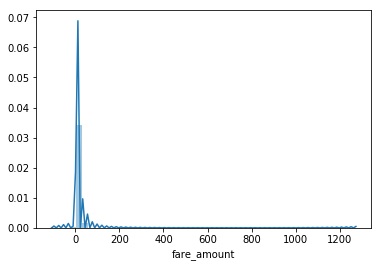

In [14]:
sns.distplot(train_df['fare_amount'])

From the distribution plot of the 'fare_amount' we see the distribution mostly lies between 0-100 and there are some values between 100-400. We might have to find what are these points that lie between 100-400 as these might be outliers so we further probe the percentiles of 'fare_amount' points

In [15]:
for i in range(0,100,10):
    var = train_df["fare_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -107.75
10 percentile value is 4.5
20 percentile value is 5.5
30 percentile value is 6.5
40 percentile value is 7.3
50 percentile value is 8.5
60 percentile value is 9.7
70 percentile value is 11.5
80 percentile value is 14.1
90 percentile value is 20.5
100 percentile value is  1273.31


In [16]:
for i in range(90,100):
    var = train_df["fare_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 20.5
91 percentile value is 21.7
92 percentile value is 23.3
93 percentile value is 25.3
94 percentile value is 27.7
95 percentile value is 30.33
96 percentile value is 33.5
97 percentile value is 38.5
98 percentile value is 46.8
99 percentile value is 53.0
100 percentile value is  1273.31


In [17]:
for i in np.arange(0.0, 1.0, 0.1):
    var = train_df["fare_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 53.0
99.1 percentile value is 56.8
99.2 percentile value is 57.33
99.3 percentile value is 57.33
99.4 percentile value is 57.33
99.5 percentile value is 57.33
99.6 percentile value is 57.33
99.7 percentile value is 58.27
99.8 percentile value is 65.5
99.9 percentile value is 80.0
100 percentile value is  1273.31


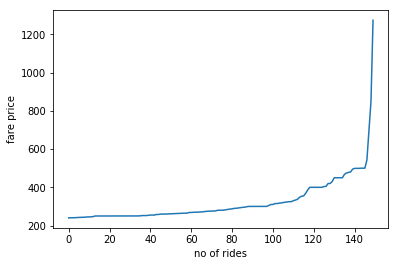

In [18]:
plt.xlabel('no of rides')
plt.ylabel('fare price')
plt.plot(var[-150:])
plt.show()

#sns.distplot(var[-100:])

There is a sudden increase in 'fare_price' for last 20-30 points

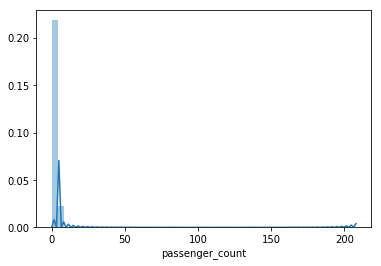

In [19]:
sns.distplot(train_df['passenger_count'])

In [20]:
a = train_df[train_df['passenger_count']<=0].shape[0] + train_df[train_df['passenger_count']>8].shape[0]

print ("Number of 'passenger_count' outliers :",a)

Number of 'passenger_count' outliers : 35181


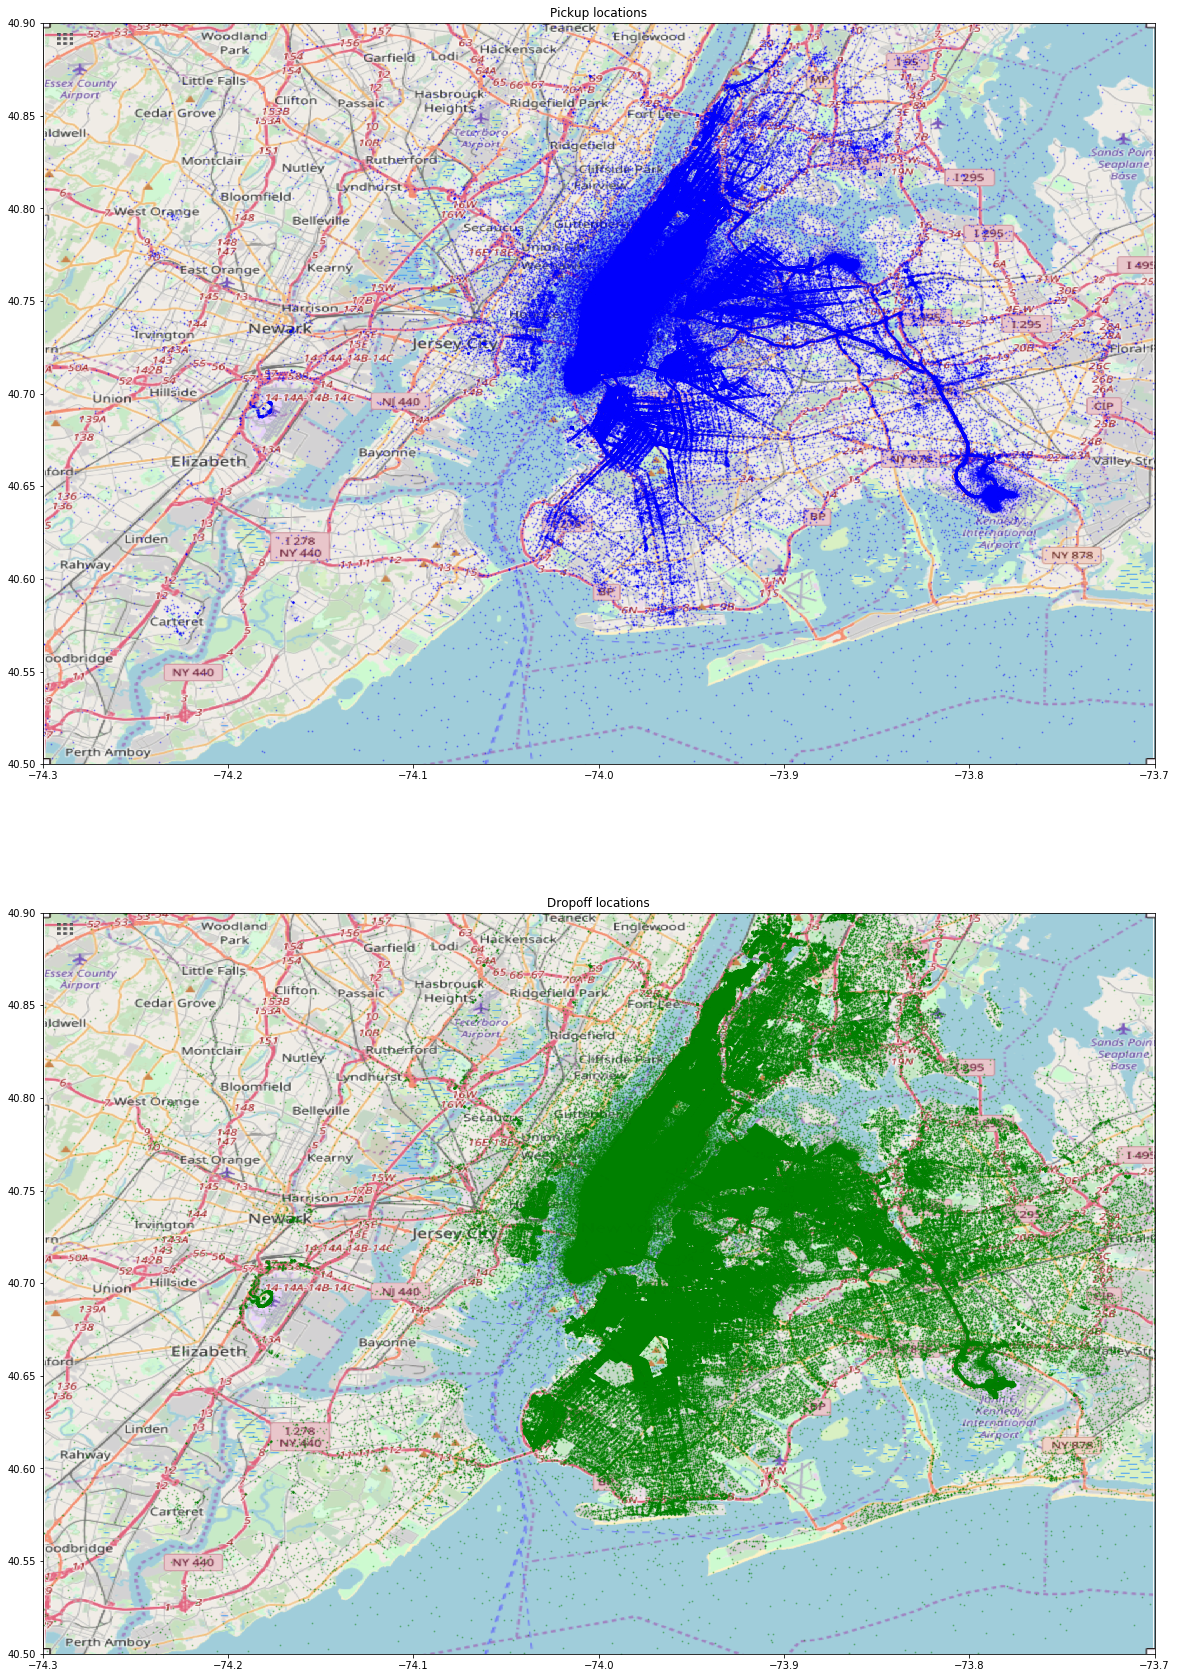

In [21]:
def plot_on_map(df, BB, nyc_map, s=30, alpha=0.2):
    fig, axs = plt.subplots(2, figsize=(30,30))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='b', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='g', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

plot_on_map(train_df, BB, nyc_map, s=1, alpha=0.3)

In [22]:
def radian_conv(degree):
    return  np.radians(degree)    

In [23]:
# To Compute Haversine distance
def haversine_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    return 2 * R_earth * np.arcsin(np.sqrt(a))

In [24]:
def add_datetime_info(dataset):
    #Convert to datetime format
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")
    
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['weekday'] = dataset.pickup_datetime.dt.weekday
    dataset['year'] = dataset.pickup_datetime.dt.year
    
    return dataset

In [28]:
def add_airport_dist(dataset):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = haversine_dist(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = haversine_dist(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = haversine_dist(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = haversine_dist(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = haversine_dist(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = haversine_dist(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon)
    
    dataset['jfk_dist'] = pickup_jfk + dropoff_jfk
    dataset['ewr_dist'] = pickup_ewr + dropoff_ewr
    dataset['lga_dist'] = pickup_lga + dropoff_lga
    
    return dataset


In [30]:
train_df = add_datetime_info(train_df)
train_df = add_airport_dist(train_df)
train_df['distance'] = haversine_dist(train_df['pickup_latitude'], train_df['pickup_longitude'], 
                                   train_df['dropoff_latitude'] , train_df['dropoff_longitude']) 
                                    
train_df['pickup_latitude'] = radian_conv(train_df['pickup_latitude'])
train_df['pickup_longitude'] = radian_conv(train_df['pickup_longitude'])
train_df['dropoff_latitude'] = radian_conv(train_df['dropoff_latitude'])
train_df['dropoff_longitude'] = radian_conv(train_df['dropoff_longitude'])




In [31]:
def add_day_phases(hour):
    if (hour>=0 and hour<5):
        return 1
    elif(hour>=5 and hour<12) :
        return 2
    elif(hour>=12 and hour <17):
        return 3
    else:
        return 4
    

day_phase=[add_day_phases(x) for x in train_df['hour'].values]


train_df['day_phase']=day_phase
train_df=train_df.drop('hour',axis=1)



In [32]:
train_df = train_df.loc[train_df['fare_amount']>0]

In [33]:
train_df=train_df.loc[train_df['passenger_count']<8]
train_df=train_df.loc[train_df['passenger_count']>0]

In [34]:
train_df=train_df.loc[(train_df.pickup_latitude!=0) & (train_df.pickup_longitude)!=0 & (train_df.dropoff_latitude!=0) & (train_df.dropoff_longitude!=0)]

In [35]:
train_df.drop(columns=['key', 'pickup_datetime'], inplace=True)

y = train_df['fare_amount']
train_df = train_df.drop(columns=['fare_amount'])


print(train_df.head())

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(train_df,y,random_state=123,test_size=0.10)


   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0         -0.022535         0.012416          -0.022531          0.012421   
1         -0.022536         0.012419          -0.022533          0.012417   
2         -0.022544         0.012404          -0.022530          0.012416   
3         -0.022541         0.012408          -0.022533          0.012414   
4         -0.022535         0.012412          -0.022533          0.012415   

   passenger_count  day  month  weekday  year      jfk_dist      ewr_dist  \
0                1   27      9        5  2014  16974.023687  17040.797458   
1                1    7      5        0  2012  16974.003909  17040.777679   
2                1    5      5        1  2009  16974.056429  17040.830192   
3                2   15      7        3  2010  16974.042699  17040.816462   
4                1   31      8        1  2010  16974.051963  17040.825730   

       lga_dist  distance  day_phase  
0  16995.393808  0.041264          

In [36]:

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
    }
    
train_set = lgbm.Dataset(x_train, y_train, silent=False,categorical_feature=['year','month','day','weekday'])
valid_set = lgbm.Dataset(x_test, y_test, silent=False,categorical_feature=['year','month','day','weekday'])
model = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500,verbose_eval=500, valid_sets=valid_set)
import pickle

filename = open('NYCTaxiFarePrediction.sav','ab')
pickle.dump(model,filename)
filename.close()

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 3.78993
[1000]	valid_0's rmse: 3.735
[1500]	valid_0's rmse: 3.71186
[2000]	valid_0's rmse: 3.69961
[2500]	valid_0's rmse: 3.68909
[3000]	valid_0's rmse: 3.68121
[3500]	valid_0's rmse: 3.67743
[4000]	valid_0's rmse: 3.6746
[4500]	valid_0's rmse: 3.67099
[5000]	valid_0's rmse: 3.66908
[5500]	valid_0's rmse: 3.6664
[6000]	valid_0's rmse: 3.66458
[6500]	valid_0's rmse: 3.66296
[7000]	valid_0's rmse: 3.66137
[7500]	valid_0's rmse: 3.66034
[8000]	valid_0's rmse: 3.65916
[8500]	valid_0's rmse: 3.65839
[9000]	valid_0's rmse: 3.6573
[9500]	valid_0's rmse: 3.65702
[10000]	valid_0's rmse: 3.65637
Did not meet early stopping. Best iteration is:
[9998]	valid_0's rmse: 3.65637


In [37]:
test_df = add_datetime_info(test_df)
test_df = add_airport_dist(test_df)
test_df['distance'] = haversine_dist(test_df['pickup_latitude'], test_df['pickup_longitude'], 
                                   test_df['dropoff_latitude'] , test_df['dropoff_longitude'])

test_df['pickup_latitude'] = radian_conv(test_df['pickup_latitude'])
test_df['pickup_longitude'] = radian_conv(test_df['pickup_longitude'])
test_df['dropoff_latitude'] = radian_conv(test_df['dropoff_latitude'])
test_df['dropoff_longitude'] = radian_conv(test_df['dropoff_longitude'])
                                                                    
test_key = test_df['key']
test_df = test_df.drop(columns=['key', 'pickup_datetime'])


/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [38]:
day_phase_1=[add_day_phases(x) for x in test_df['hour'].values]
test_df['day_phase']=day_phase_1

In [39]:
test_df=test_df.drop('hour',axis=1)

In [40]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11084772 entries, 0 to 11084771
Data columns (total 14 columns):
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
day                  int64
month                int64
weekday              int64
year                 int64
jfk_dist             float64
ewr_dist             float64
lga_dist             float64
distance             float64
day_phase            int64
dtypes: float64(8), int64(6)
memory usage: 1.2 GB


In [ ]:
y_predicted = model.predict(test_df)

In [ ]:
submission = pd.DataFrame(
    {'key': test_key, 'fare_amount': y_predicted},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)
